In [84]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import sys
%matplotlib inline
sns.set()

In [206]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X']
y = (np.zeros(50000)).reshape(5000, 10)
theta1 = np.array(weights['Theta1'])
theta2 = np.array(weights['Theta2'])
theta2.shape

(10, 26)

In [86]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1

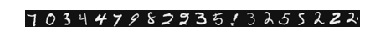

In [87]:
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [182]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [183]:
def hypothesisFunction (x, theta1, theta2):
    a1 = np.c_[np.ones((data['X'].shape[0], 1)), x]
    z2 = np.dot(a1, theta1.T)
    
    a2 = np.c_[np.ones((data['X'].shape[0], 1)), sigmoidFunction(z2)]
    z3 = np.dot(a2, theta2.T)
    
    a3 = sigmoidFunction(z3)
    return a3

In [184]:
def costFunction (y, hypothesisFunction):
    m = y.shape[0]
    j = (1 / m) * (np.log(hypothesisFunction).T.dot(-y) - np.log(1 - hypothesisFunction).T.dot(1 - y))
    return j

In [185]:
c = costFunction (y, hypothesisFunction (x, theta1, theta2))
costs = []
for number in range(10):
    costs.append(c[number, number])
mainCosts = np.array(costs)

In [188]:
def regularizedCostFunction (costs, theta1, theta2, λ):
    m = y.shape[0]
    costs += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return costs

In [194]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))

In [205]:
randomTheta1 = np.random.uniform(low = -0.12, high = 0.12, size = (25, 400))
randomTheta2 = np.random.uniform(low = -0.12, high = 0.12, size = (10, 25))

array([ 0.09404898,  0.02589311,  0.08158719,  0.03017832, -0.08230573,
        0.07445133,  0.08148913,  0.11945514, -0.06945398,  0.09452466,
        0.00909226, -0.11324863, -0.09328912, -0.0687822 , -0.06918055,
        0.02090163,  0.11757824, -0.06861789,  0.06197137,  0.02453464,
        0.06300883,  0.05606336, -0.02375768, -0.05626424,  0.06963536,
       -0.11580368,  0.00524104,  0.04023932, -0.00789103, -0.00391377,
        0.024583  ,  0.06486084, -0.09523311,  0.10953202,  0.1090455 ,
        0.05974641, -0.01643543,  0.11745956, -0.06836113, -0.06138704,
        0.08257853, -0.02896711, -0.0590416 ,  0.02500446,  0.01620924,
       -0.05468832,  0.04657544, -0.0957701 , -0.00157938,  0.01071592,
        0.04755824,  0.05778911,  0.03317235, -0.06212675,  0.00858277,
       -0.04021017, -0.00577341,  0.09345215,  0.04718665,  0.08600463,
       -0.08909346, -0.09394729, -0.00645325, -0.05085978,  0.05269362,
        0.10711162, -0.1137321 , -0.0127173 , -0.05857665, -0.03